In [1]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm  # Прогресс-бар
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind

%matplotlib inline
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250220'
}

Задача:
Провести симуляцию A/B-теста с использованием Монте-Карло, чтобы оценить мощность теста при предположении, что новый алгоритм рекомендаций увеличивает число просмотров на пользователя. В ходе эксперимента используются реальные распределения просмотров и CTR с периода A/A-теста.


<Axes: ylabel='Count'>

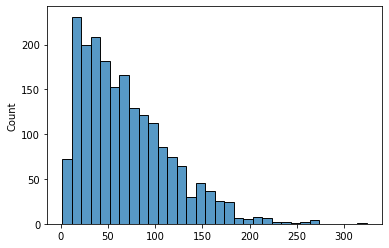

In [2]:
# Выгружаю распределение просмотров на пользователя за период A/A-теста
# Использую диапазон 2025-01-24 по 2025-01-30
# Эти данные нужны для симуляции поведения пользователей
q_views = """
select views, count() as users
from (select 
    user_id,
    sum(action = 'view') as views
from {db}.feed_actions 
where toDate(time) between '2025-01-24' and '2025-01-30'
group by user_id
)
group by views
order by views
"""


views = pandahouse.read_clickhouse(q_views, connection=connection)
views['p'] = views['users']/views.users.sum()
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views['views'], 
                                        views['p']))
sns.histplot(views_distr.rvs(size=2000))

In [3]:
# Выгружаю распределение по пользовательским CTR (лайки / просмотры)
# Также на период A/A-теста
q_ctr = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from {db}.feed_actions
where dt between '2025-01-24' AND '2025-01-30'
group by dt,user_id
)
group by ctr
"""

ctr = pandahouse.read_clickhouse(q_ctr, connection=connection)
#для дальнейшей выборки с заданным распределением
views['p'] = views['users'] / views['users'].sum() 
ctr['p'] = ctr['users'] / ctr['users'].sum() 


In [4]:
# Симуляция Монте-Карло: оценим мощность A/B-теста при условии гипотетического эффекта
# Предположим, что алгоритм увеличивает просмотры на 1-2 с вероятностью 90%, если их изначально >= 50
# Количество симуляций: 20 000
# Цель: оценить, с какой вероятностью t-тест обнаружит значимое отличие в лайках между группами

rng = np.random.default_rng()

n = views.users.sum() // 2

num_simulations = 20000
result_list = []
# Случайным образом создаем группы A и B, используя распределение просмотров
# Группа B: применяем эффект от алгоритма (увеличиваем просмотры согласно описанному правилу)
for i in tqdm(range(num_simulations)):
    group_A_views = rng.choice(views['views'], size=n, replace=True, p=views['p']).astype(np.int64)
    group_B_views = rng.choice(views['views'], size=n, replace=True, p=views['p']).astype(np.int64)
    
    group_B_views = group_B_views + ((1 + rng.binomial(1, 0.5, size=n)) * rng.binomial(1, 0.9, size=n)) * (group_B_views >= 30)
    
    group_A_ctr = rng.choice(ctr['ctr'], size=n, replace=True, p=ctr['p'])
    group_B_ctr = rng.choice(ctr['ctr'], size=n, replace=True, p=ctr['p'])
    
    group_A_likes = rng.binomial(group_A_views, group_A_ctr)
    group_B_likes = rng.binomial(group_B_views, group_B_ctr)
    
    result_list.append(stats.ttest_ind(group_B_likes, group_A_likes, equal_var=False).pvalue < 0.05)

# Рассчитаем долю симуляций, где p-value < 0.05. Это и есть оценка статистической мощности теста в процентах.

result = (sum(result_list) / num_simulations) * 100
print(f"Финальный результат: мощность теста {result} %")

100%|██████████| 20000/20000 [05:17<00:00, 62.97it/s]

Финальный результат: мощность теста 41.555 %
